In [1]:
# Importing the libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import io
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import string
nltk.download('stopwords')
nltk.download('words')
from sklearn.feature_extraction.text import CountVectorizer
import warnings
warnings.filterwarnings('ignore')
from wordcloud import WordCloud,STOPWORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.metrics import roc_curve,auc,roc_auc_score,confusion_matrix

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/dagdasy/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/dagdasy/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [2]:
# loading dataframe
df = pd.read_csv('train.csv')

In [3]:
# getting a glance at the dataframe
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   id             159571 non-null  object
 1   comment_text   159571 non-null  object
 2   toxic          159571 non-null  int64 
 3   severe_toxic   159571 non-null  int64 
 4   obscene        159571 non-null  int64 
 5   threat         159571 non-null  int64 
 6   insult         159571 non-null  int64 
 7   identity_hate  159571 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


In [5]:
# checking missing values
df.isna().sum()

id               0
comment_text     0
toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
dtype: int64

In [6]:
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [7]:
df.loc[(df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=1) != 0),'clean'] = 0
df.loc[(df[['toxic','severe_toxic','obscene','threat','insult','identity_hate']].sum(axis=1) == 0),'clean']= 1

In [8]:
df.clean.sum()

143346.0

In [9]:
# assigning a new label that is not flagged as 'toxic', 'severe_toxic', 'obscene', 'threat', 
# 'insult', and 'identity_hate'

df[(df.toxic !=1) & (df.severe_toxic != 1) & (df.obscene !=1) &(df.threat !=1) & (df.insult !=1) & (df.identity_hate !=1)]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1.0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1.0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1.0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1.0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0,1.0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0,1.0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0,1.0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0,1.0


In [10]:
# calculating length of each comment
df['comment_length'] = df['comment_text'].astype(str).apply(len)

# calculating number of words within each comment
df['word_count'] = df['comment_text'].apply(lambda x: len(str(x).split()))

# Data Cleaning

Even though data cleaning involves pretty much same steps for all of the NLP projects, their order or implementation changes with respect to the text in the data. Here are the main steps of the data cleaning for NLP:
* Removing HTML characters,ASCII
* Convert Text to Lowercase  (Normalizing)
* Remove Punctuation's
* Remove Stop words
* Tokenization
* Stemming vs Lemmatization

**Data cleaning Steps:**

1. Replacing "\n" and "\" with a space followed by normalization and removal of words that start with "http" and "wiki". 
2. Removal of stop words and punctuations. 
3. Removal of numbers and extra spaces.
4. Removal of any word that is not in NLTK corpus (Later on I saw that this step causes removal of most common words of several labels do decided not to use it).
5. Lemmatization

In [11]:
# assigning the stop words
stop = stopwords.words('english')
#updating stop words
stop.append("can't")
stop.append("eg")
set(stop)
# assigning the punctuations
punc = set(string.punctuation) 

In [12]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [13]:
def clean_1(text):   
    ### This function does three things
    ### 1. substitute '\n' with space 2. substitute '\' with space 3. makes string lowercase
    text = re.sub(r'\n'," ",text)
    text = re.sub(r"\"",r" ",text)
    text = text.lower()
    text = re.sub('http.*',' ',text)
    # removing words that start with 'wiki'
    text = re.sub(r'wiki.*',' ',text)
    return text

In [14]:
def clean_2(text):
    #splitting the string into words and remving stop words
    text = " ".join([i for i in text.split() if i not in stop])
    #replacing punctuations with space
    text = ''.join(' ' if i in punc else i for i in text)
    return text

In [15]:
def clean_3(text):
    # removing links that start with 'http'
    #text = re.sub('http.*',' ',text)
    # removing words that start with 'wiki'
    #text = re.sub(r'wiki.*',' ',text)
    # removing punctuations
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    # removing numbers
    text = re.sub(r'[^a-zA-Z]', ' ', text)
    # removing extra spaces
    text = re.sub(' +', ' ', text)
    return text

In [16]:
#assigning English words
words = set(nltk.corpus.words.words())
# removes words that are not in English
def clean_4(text):
    return " ".join(w for w in nltk.wordpunct_tokenize(text) if w.lower() in words or not w.isalpha())

In [17]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
# performs lemmatization on tokenized string
def lemmatize_text(text):
    return " ".join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

In [18]:
# function to perform count vectorization
def vectorizer(dataframe,column,min_df):
    cv = CountVectorizer(stop_words='english',min_df=min_df)
    df_cv = cv.fit_transform(dataframe[column])
    df_dtm = pd.DataFrame(df_cv.toarray(), columns=cv.get_feature_names())
    df_dtm.index = dataframe.index
    return df_dtm

In [19]:
# cleaning the data
# 1. substitute '\n' with space 2. substitute '\' with space 3. makes string lowercase
df['text_1'] = df.comment_text.apply(clean_1)
#making words lower case, removing stop words and replacing punctuations with space
df['text_2'] = df.text_1.apply(clean_2)
#removing links, words that start with wiki, numbers and extra spaces
df['text_3'] = df.text_2.apply(clean_3)
# removing words that are not present in English dictionary
df['text_4'] = df.text_3.apply(clean_4)
#lemmatization
df['lemma1'] = df['text_3'].apply(lemmatize_text)
#lemmatization
df['lemma2'] = df['text_4'].apply(lemmatize_text)

***Let's compare raw text with cleaning steps:***

In [20]:
df.comment_text[3]

'"\nMore\nI can\'t make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of ""types of accidents""  -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It\'s listed in the relevant form eg Wikipedia:Good_article_nominations#Transport  "'

In [21]:
df.text_1[3]

"  more i can't make any real suggestions on improvement - i wondered if the section statistics should be later on, or a subsection of   types of accidents    -i think the references may need tidying so that they are all in the exact same format ie date format etc. i can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.  there appears to be a backlog on articles for review so i guess there may be a delay until a reviewer turns up. it's listed in the relevant form eg  "

In [22]:
df.text_2[3]

'make real suggestions improvement   wondered section statistics later on  subsection types accidents  i think references may need tidying exact format ie date format etc  later on  no one else first   preferences formatting style references want please let know  appears backlog articles review guess may delay reviewer turns up  listed relevant form'

In [23]:
df.text_3[3]

'make real suggestions improvement wondered section statistics later on subsection types accidents i think references may need tidying exact format ie date format etc later on no one else first preferences formatting style references want please let know appears backlog articles review guess may delay reviewer turns up listed relevant form'

In [24]:
df.text_4[3]

'make real improvement section statistics later on subsection i think may need exact format ie date format later on no one else first style want please let know backlog review guess may delay reviewer turns up listed relevant form'

In [25]:
df.lemma1[3]

'make real suggestion improvement wondered section statistic later on subsection type accident i think reference may need tidying exact format ie date format etc later on no one else first preference formatting style reference want please let know appears backlog article review guess may delay reviewer turn up listed relevant form'

In [26]:
df.lemma2[3]

'make real improvement section statistic later on subsection i think may need exact format ie date format later on no one else first style want please let know backlog review guess may delay reviewer turn up listed relevant form'

**Note:** Looks like final step of cleaning that removes words which are not in English dictionary, removes common words too. Let's take a look at the most common words found in comments that are classified as toxic. We will use CountVectorizer to quantify the words. 

In [27]:
# appying the vectorizer function to each step of text cleaning
df_toxic_0=vectorizer(df[df.toxic==1],'comment_text',min_df=1)
df_toxic_1=vectorizer(df[df.toxic==1],'text_1',min_df=1)
df_toxic_2=vectorizer(df[df.toxic==1],'text_2',min_df=1)
df_toxic_3=vectorizer(df[df.toxic==1],'text_3',min_df=1)
df_toxic_4=vectorizer(df[df.toxic==1],'text_4',min_df=1)
df_lemma1=vectorizer(df[df.toxic==1],'lemma1',min_df=1)
df_lemma2=vectorizer(df[df.toxic==1],'lemma2',min_df=1)

In [28]:
# creating data frame by identifying most common 10 words for each data cleaning step
t0_df = pd.DataFrame((df_toxic_0.sum(axis=0)).sort_values(ascending=False).head(10))
t1_df = pd.DataFrame((df_toxic_1.sum(axis=0)).sort_values(ascending=False).head(10))
t2_df = pd.DataFrame((df_toxic_2.sum(axis=0)).sort_values(ascending=False).head(10))
t3_df = pd.DataFrame((df_toxic_3.sum(axis=0)).sort_values(ascending=False).head(10))
t4_df = pd.DataFrame((df_toxic_4.sum(axis=0)).sort_values(ascending=False).head(10))
lemma1_df = pd.DataFrame((df_lemma1.sum(axis=0)).sort_values(ascending=False).head(10))
lemma2_df = pd.DataFrame((df_lemma2.sum(axis=0)).sort_values(ascending=False).head(10))

In [29]:
# Comparing step 3 with step 4:
print('Most common words after 3rd step of cleaning: \n')
print(t3_df,'\n')
print('Most common words after 4th step of cleaning: \n')
print(t4_df)

Most common words after 3rd step of cleaning: 

            0
fuck     9222
nigger   3283
shit     3176
suck     3157
fucking  2922
ass      2819
like     2782
hate     2258
gay      2169
die      1948 

Most common words after 4th step of cleaning: 

           0
nigger  3283
suck    3157
ass     2819
like    2782
hate    2258
gay     2169
die     1948
fat     1944
know    1872
moron   1831


**Note:** 4th step of cleaning removes common words with high count which could be important for the model. So we will not use the 4th cleaning step. Let's visualize it using wordcloud.

In [30]:
def wordcloudmaker_column(dataframe,category,column):   
    plt.figure(figsize=(40,25))
    for i in range(len(column)):
        data = dataframe[dataframe[category]==1]
        text = data[column[i]].values
        cloud = WordCloud(
                          
                          background_color='white',
                          max_font_size=100, 
                          max_words=30, 
                          collocations=False).generate(" ".join(text))
        
        plt.subplot(len(column),1,i+1)
        plt.axis('off')
        plt.title(column[i],fontsize=20)
        plt.imshow(cloud)
        plt.subplots_adjust(wspace=None, hspace=None)

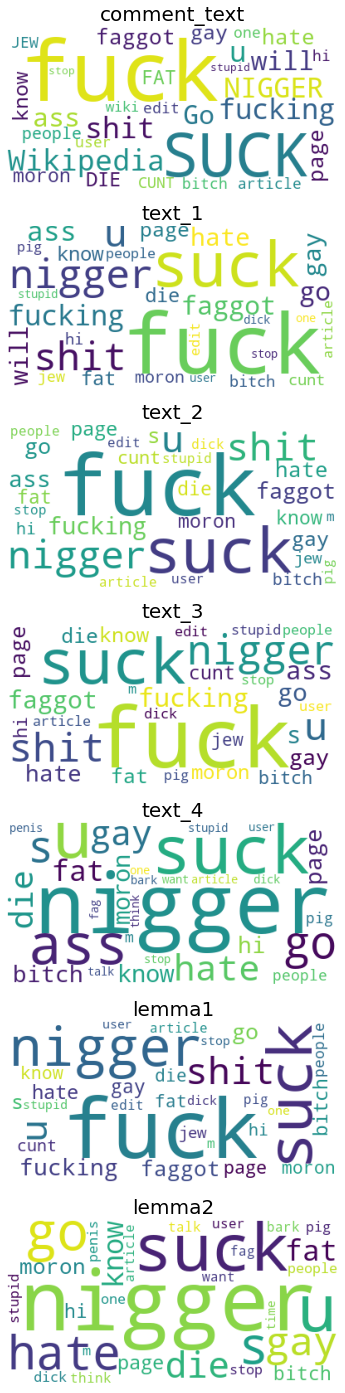

In [31]:
column=['comment_text','text_1', 'text_2', 'text_3', 'text_4','lemma1','lemma2']
wordcloudmaker_column(df,'toxic',column)

# Exploratory Data Analysis:

In [32]:
# counting the number of comments for each category
categories = ['clean','toxic','severe_toxic','obscene','threat','insult','identity_hate']
counts=[]
for i in categories:
    counts.append(df[i].value_counts()[1])

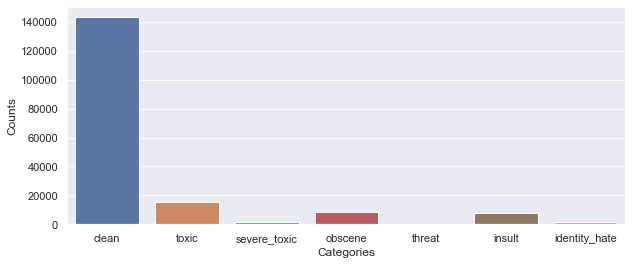

In [33]:
# plotting the number of comments for each category

sns.set(rc={'figure.figsize':(10,4)})
sns.barplot(x=categories,y=counts)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

**Note:**  Creating word cloud for each category.

In [34]:
# function to plot wordcloud for each category
def wordcloudmaker(dataframe,column):
    plt.figure(figsize=(40,25))
    for i in range(len(categories)):
        data = df[df[categories[i]]==1]
        text = data[column].values
        cloud = WordCloud(
                          stopwords=STOPWORDS,
                          background_color='WHITE',
                          collocations=False,
                          max_font_size=100, 
                          max_words=30
                         ).generate(" ".join(text))
        plt.subplot(len(categories),1,i+1)
        plt.axis('off')
        plt.title(categories[i],fontsize=10)
        plt.imshow(cloud)

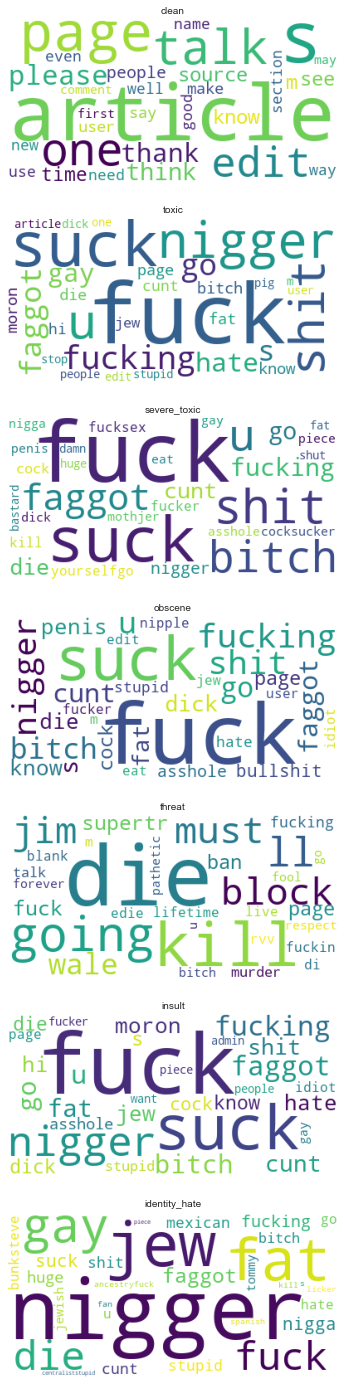

In [35]:
wordcloudmaker(df,'lemma1')

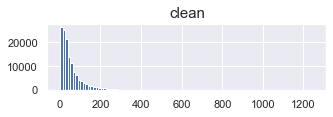

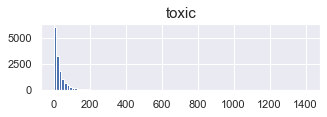

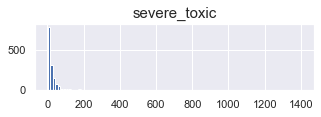

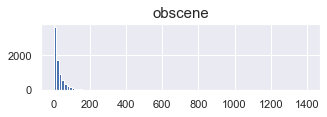

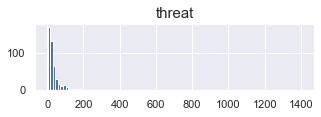

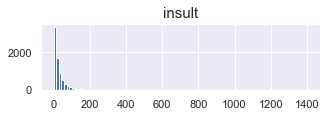

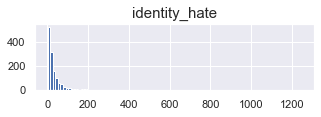

In [36]:
plt.rcParams["figure.figsize"] = (5,10)

for i in range(len(categories)):
    data = df[df[categories[i]] ==1]
    plt.subplot(len(categories),1,i+1)
    plt.hist(data=data, x='word_count',bins=100)
    #plt.axis('off')
    plt.title(categories[i],fontsize=15)
    plt.show()

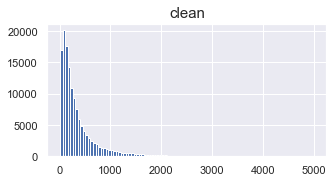

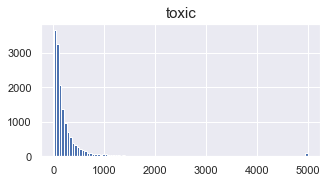

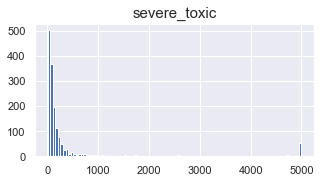

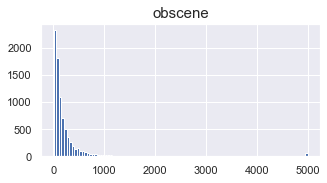

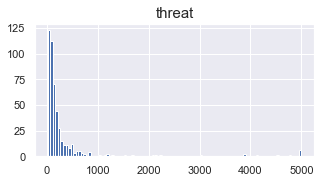

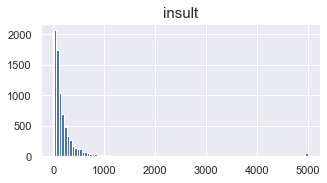

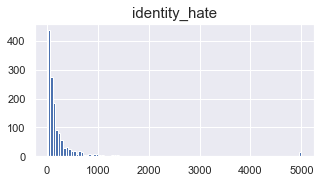

In [37]:
plt.rcParams["figure.figsize"] = (5,20)

for i in range(len(categories)):
    data = df[df[categories[i]] ==1]
    plt.subplot(len(categories),1,i+1)
    plt.hist(data=data, x='comment_length',bins=100)
    #plt.axis('off')
    plt.title(categories[i],fontsize=15)
    plt.show()

Based on comment length and word count distributions, it is clear that 'clean' comments tend to be longer than other comments.